In [10]:
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

In [2]:
with open('Myfeatures2.pickle', 'rb') as f:
    PGNfeatures = pickle.load(f)
    elos = pickle.load(f)

In [3]:
stockfish = pd.read_csv('../givenData/stockfish/stockfish.csv')
stockfish.MoveScores = stockfish.MoveScores.str.replace('NA','').str.split()
stockfish.MoveScores = stockfish.MoveScores.apply(lambda x: np.asarray(x, dtype=int))
stockfish.drop('Event', axis=1, inplace=True)
#stockfish.index = list(range(0, 2*len(ecos),2))
stockfish.head()

,MoveScores
0,"[18, 17, 12, 8, -5, 12, 3, -2, 22, 21, 20, 13,..."
1,"[26, 44, 26, 18, 14, 34, 36, 31, 37, 35, 42, 5..."
2,"[26, 51, 68, 57, 65, 77, 48, 93, 61, 63, 63, 5..."
3,"[2, 21, 5, 53, 35, 45, 37, 54, 10, 22, 8, 48, ..."
4,"[26, 64, 35, 53, 18, 20, 18, 20, 10, 49, 60, 9..."


In [4]:
def extract_score_features(scores):
    features = dict()
    if scores.size == 0:
        return features
    scores = np.r_[0, scores]
    abs_scores = np.abs(scores)
    diffs = np.diff(scores)
    white_diffs = diffs[::2]
    black_diffs = diffs[1::2]
    subset_names = ['diffs', 'white_diffs', 'black_diffs']
    subsets = [diffs, white_diffs, black_diffs]
    stats = [np.min, np.max, np.mean, lambda x: np.median(np.abs(x))]
    stat_names = ['min', 'max', 'mean', 'median_abs']
    for subset, subset_name in zip(subsets, subset_names):
        for stat, stat_name in zip(stats, stat_names):
            features[stat_name + '_' + subset_name] = stat(subset)
            # np.hi
    features['advantage120_idx'] = np.argmax(abs_scores > 120) or len(scores)
    features['advantage70_idx'] = np.argmax(abs_scores > 70) or len(scores)
    return features
stockfishScores = stockfish.MoveScores.apply(extract_score_features).tolist()

In [13]:
pgnvec = DictVectorizer()
X_pgn = pgnvec.fit_transform(PGNfeatures)
names_pgn = pgnvec.get_feature_names()
pgn_pd = pd.DataFrame(X_pgn.toarray(), columns=names_pgn)

In [17]:
stockvec = DictVectorizer()
X_stock = stockvec.fit_transform(stockfishScores)
scores_pd = pd.DataFrame(X_stock.toarray(), columns=stockvec.get_feature_names())

In [20]:
full_games_pd = pgn_pd.join(scores_pd)

In [22]:
full_games_pd.columns.shape

(59,)

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [44]:
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.5)
sns.despine(left=True)

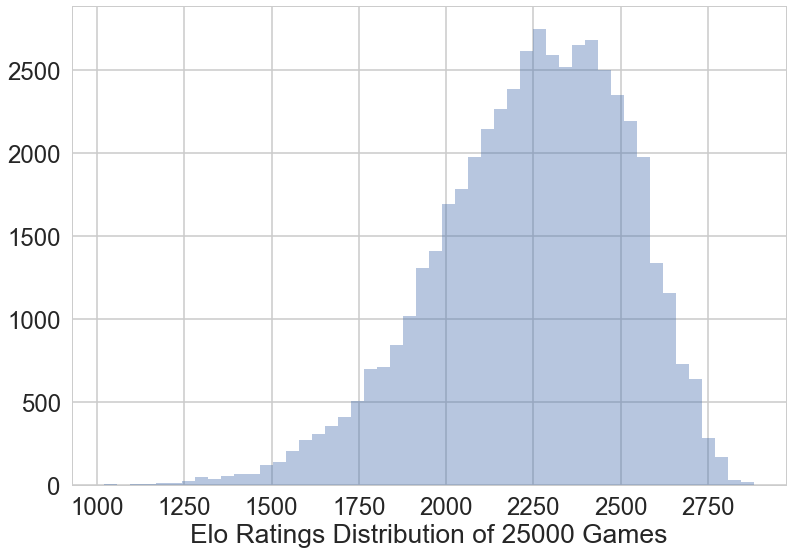

In [45]:
sns.distplot(elos, kde=False, axlabel='Elo Ratings Distribution of 25000 Games')

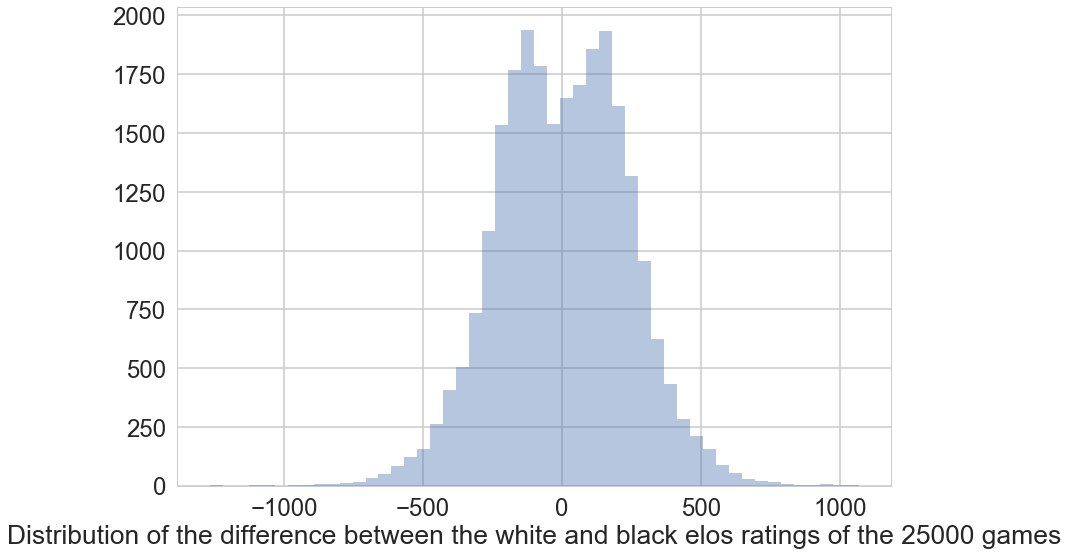

In [46]:
elo_diff = np.array(elos[::2]) - np.array(elos[1::2])
sns.distplot(elo_diff, kde=False, axlabel="Distribution of the difference between the white and black elos ratings of the 25000 games")

In [37]:
ply_num = [len(stockfish.MoveScores[i]) for i in range(stockfish.last_valid_index() + 1)]
ply_num_train = ply_num[:25000]
elo_diff_abs = np.abs(elo_diff)

<Container object of 25000 artists>

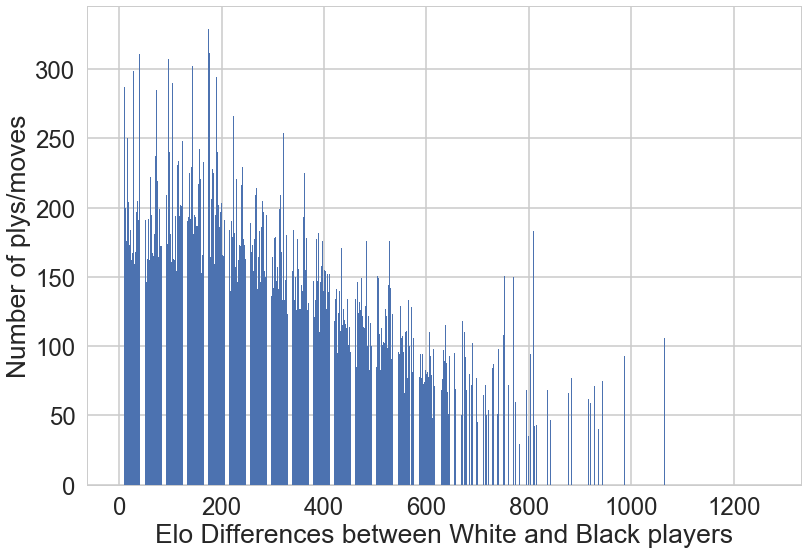

In [47]:
plt.xlabel("Elo Differences between White and Black players")
plt.ylabel("Number of plys/moves")
plt.bar(elo_diff_abs, ply_num_train)

In [49]:
results = []
results_f = open("C:/Users/Meers/Documents/Techie/chessKaggle/givenData/data/result.txt")
res_text = results_f.read()
res_txt_list = res_text.split("\n")
#print(res_txt_list)
for i in range(0, (len(res_txt_list) - 1),2):
    if (res_txt_list[i] == '1'):
        results.append('White')
    elif(res_txt_list[i] == '0'):
        results.append('Black')
    else:
        results.append('Draw')
len(results)

50000

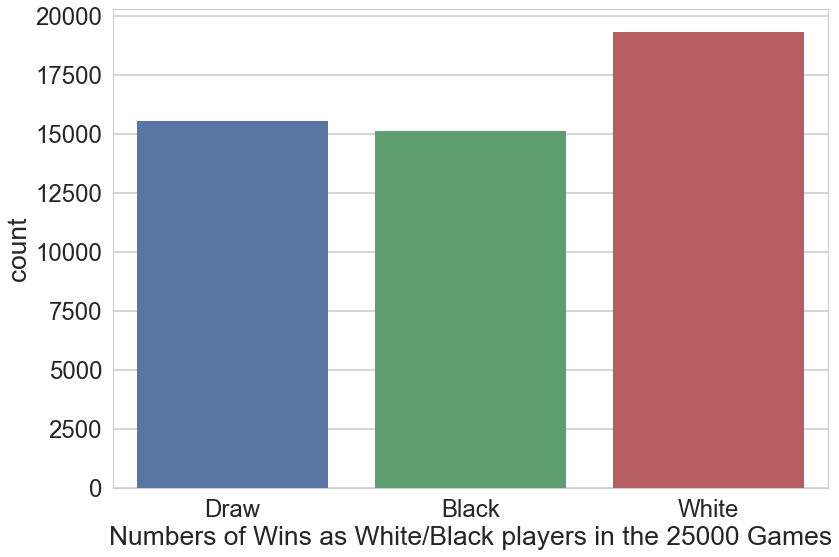

In [56]:
results_pd = pd.DataFrame(results, columns=["Numbers of Wins as White/Black players in the 25000 Games"])
sns.countplot(x="Numbers of Wins as White/Black players in the 25000 Games", data=results_pd)